# 1. Подготовка

In [99]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
from numpy import abs

In [67]:
#импорт данных
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB
None


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [68]:
#ресемплирование
print('Индекс монотонный:', data.index.is_monotonic)
data_resampled = data.resample('1H').sum()

Индекс монотонный: True


# 2. Анализ

In [69]:
#начальная и конечная дата
print('Начальная дата:', data.index.min(), 'Конечная дата:', data.index.max())

Начальная дата: 2018-03-01 00:00:00 Конечная дата: 2018-08-31 23:50:00


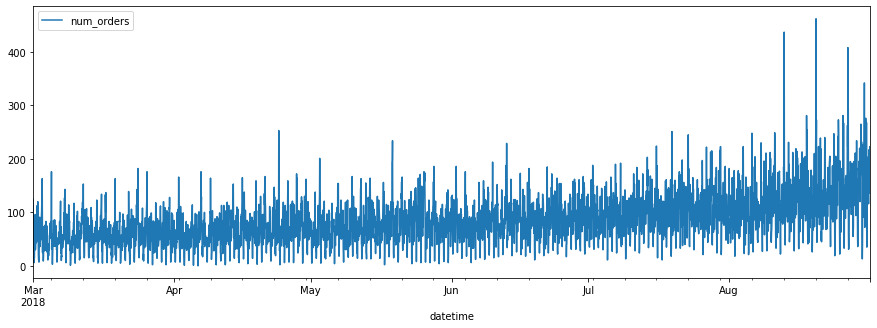

In [70]:
data_resampled.plot(figsize=(15, 5))

График трудночитаемый. Ресемплируем данные по неделям и посмотрим на такой график.

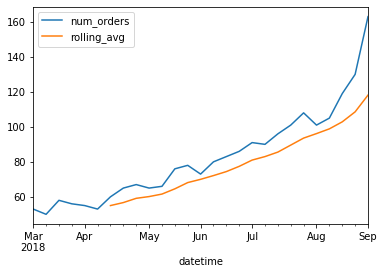

In [71]:
#посмотрим график за неделю
data_week = data_resampled.resample('1W').median().round(0) #медиана - чтобы график был более устойчив к выбросам
#добавим скользящее среднее
data_week['rolling_avg'] = data_week.rolling(7).mean()
data_week.plot()

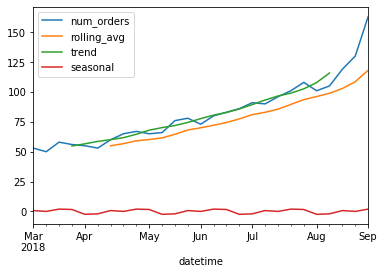

In [72]:
#проверка на сезонность
data_week_decomposed = seasonal_decompose(data_week.drop('rolling_avg', axis=1), freq=6) #без freq=6 вылетает ошибка
data_week['trend'] = data_week_decomposed.trend
data_week['seasonal'] = data_week_decomposed.seasonal
data_week.plot()

Линия тренда сонаправлена скользящему среднему. Количество заказов растет. Сезонность посмотрим на срезе трех месяцев с мая по июль.

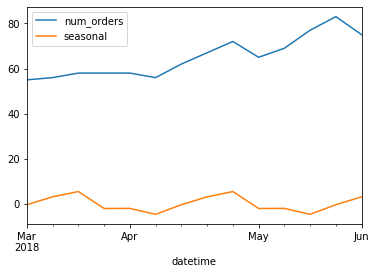

In [73]:
data_3_months = data_resampled['2018-03-01':'2018-05-31'].resample('1W').mean().round(0)
data_3_months['seasonal'] = seasonal_decompose(data_3_months, freq=6).seasonal
data_3_months.plot()

На графике видно, что сезонным является спад количества заказов в начале месяца и рост, достигающий пика на 2-3 неделе месяца.

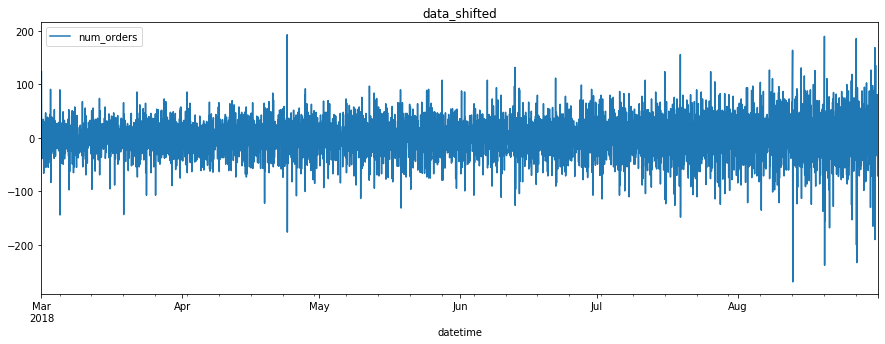

In [74]:
#разность временного ряда
data_shifted = data_resampled - data_resampled.shift(fill_value=0)
data_shifted.plot(title='data_shifted', figsize=(15, 5))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


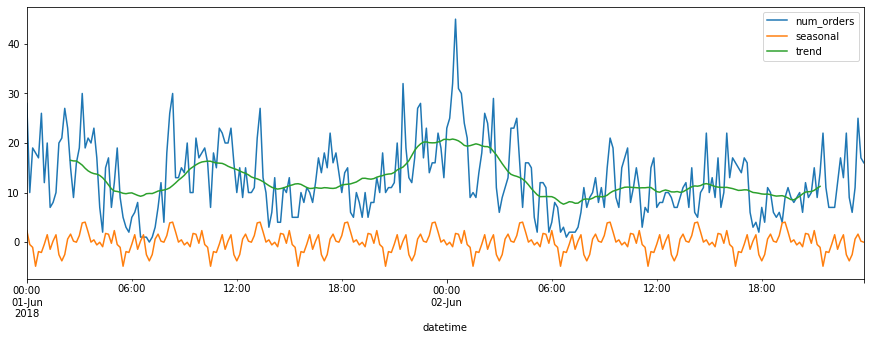

In [75]:
#анализ данных по часам за 2 дня
data_day = data['2018-06-01':'2018-06-02']
data_day['seasonal'] = seasonal_decompose(data_day, freq=30).seasonal
data_day['trend'] = seasonal_decompose(data_day['num_orders'], freq=30).trend
data_day.plot(figsize=(15, 5))

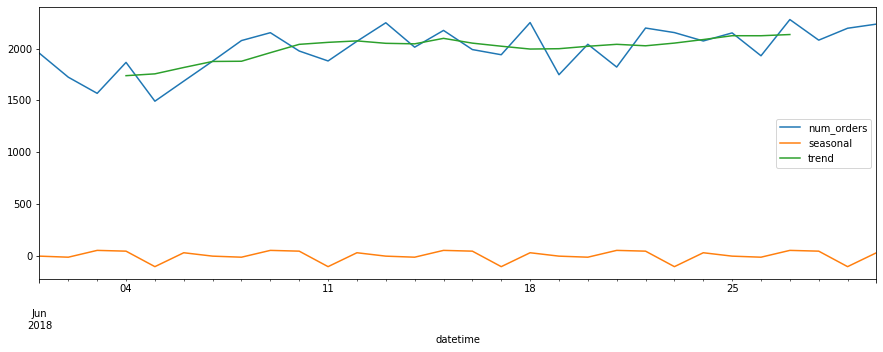

In [76]:
#анализ данных по дням за месяц
data_week_sample = data['2018-06-01':'2018-06-30']
data_week_sample = data_week_sample.resample('1D').sum()
data_week_sample['seasonal'] = seasonal_decompose(data_week_sample, freq=6).seasonal
data_week_sample['trend'] = seasonal_decompose(data_week_sample['num_orders']).trend
data_week_sample.plot(figsize=(15, 5))

In [77]:
data_week_sample['dayofweek'] = data_week_sample.index.dayofweek
display(data_week_sample)

,num_orders,seasonal,trend,dayofweek
datetime,,,,
2018-06-01,1956,-4.166667,NaN,4
2018-06-02,1725,-14.333333,NaN,5
2018-06-03,1569,51.500000,NaN,6
2018-06-04,1868,44.000000,1739.714286,0
2018-06-05,1493,-105.666667,1757.285714,1
2018-06-06,1687,28.666667,1818.714286,2
2018-06-07,1880,-4.166667,1877.142857,3
2018-06-08,2079,-14.333333,1879.142857,4
2018-06-09,2155,51.500000,1961.857143,5


**Выводы.**
- Данные доступны с 01.03.2018 по 31.08.2018;
- Даты расположены в хронологическом порядке, сортировка не требуется;
- Линии тренда и скользящие средние направлены вверх. Количество заказов растет;
- Наблюдается сезонный спад количества заказов в начале месяца и максимум на 2-3 неделю месяца;
- График разности временных рядов стационарен (распределение не меняется со временем). Поэтому для лучшего обучения модели будем добавлять смещенные признаки.

# 3. Обучение

In [78]:
#создание признаков
#data_resampled['month'] = data_resampled.index.month
data_resampled['week'] = data_resampled.index.week
data_resampled['dayofweek'] = data_resampled.index.dayofweek
data_resampled['day'] = data_resampled.index.day
data_resampled['hour'] = data_resampled.index.hour

#смещенные признаки
data_resampled['lag_1'] = data_resampled['num_orders'].shift(1)
data_resampled['lag_2'] = data_resampled['num_orders'].shift(2)
data_resampled['lag_3'] = data_resampled['num_orders'].shift(3)

#скользящее среднее
data_resampled['rolling_avg'] = data_resampled['num_orders'].rolling(5).mean()

In [79]:
print(data_resampled.info())
data_resampled.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 9 columns):
num_orders     4416 non-null int64
week           4416 non-null int64
dayofweek      4416 non-null int64
day            4416 non-null int64
hour           4416 non-null int64
lag_1          4415 non-null float64
lag_2          4414 non-null float64
lag_3          4413 non-null float64
rolling_avg    4412 non-null float64
dtypes: float64(4), int64(5)
memory usage: 505.0 KB
None


,num_orders,week,dayofweek,day,hour,lag_1,lag_2,lag_3,rolling_avg
datetime,,,,,,,,,
2018-03-01 00:00:00,124,9,3,1,0,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,9,3,1,1,124.0,NaN,NaN,NaN
2018-03-01 02:00:00,71,9,3,1,2,85.0,124.0,NaN,NaN
2018-03-01 03:00:00,66,9,3,1,3,71.0,85.0,124.0,NaN
2018-03-01 04:00:00,43,9,3,1,4,66.0,71.0,85.0,77.8


In [80]:
#дроп неизвестных значений - потеря 4 записей не критична, при этом не будет проблем при обучении моделей
data_resampled = data_resampled.dropna()
data_resampled.head()

,num_orders,week,dayofweek,day,hour,lag_1,lag_2,lag_3,rolling_avg
datetime,,,,,,,,,
2018-03-01 04:00:00,43,9,3,1,4,66.0,71.0,85.0,77.8
2018-03-01 05:00:00,6,9,3,1,5,43.0,66.0,71.0,54.2
2018-03-01 06:00:00,12,9,3,1,6,6.0,43.0,66.0,39.6
2018-03-01 07:00:00,15,9,3,1,7,12.0,6.0,43.0,28.4
2018-03-01 08:00:00,34,9,3,1,8,15.0,12.0,6.0,22.0


In [81]:
#разбивка на признаки и целевой признак
features = data_resampled.drop('num_orders', axis=1)
target = data_resampled['num_orders']

#разбивка на обучающую и тестовую выборки
features_train1, features_test, target_train1, target_test = train_test_split(features, target, test_size=0.1, shuffle=False)

#разбивка обучающей выборки на обучающую и валидационную
features_train, features_valid, target_train, target_valid = train_test_split(features_train1,
                                                                              target_train1,
                                                                              test_size=0.1,
                                                                              shuffle=False)

In [82]:
#модель линейной регрессии
model_linear = LinearRegression()
model_linear.fit(features_train, target_train)
predictions_valid = model_linear.predict(features_valid)
score = sqrt(mean_squared_error(target_valid, predictions_valid))
print('RMSE линейной регрессии на валидационной выборке:', score)

RMSE линейной регрессии на валидационной выборке: 29.742812103635426


In [83]:
%%time
#модель случайного леса - подбор количества деревьев
for n in range(10, 110, 10):
    model_forest = RandomForestRegressor(n_estimators=n, max_depth=50, random_state=12345)
    model_forest.fit(features_train, target_train)
    predictions = model_forest.predict(features_valid)
    score = sqrt(mean_squared_error(target_valid, predictions))
    print('RMSE модели случайного леса, n_estimators=', n, ':', score)

RMSE модели случайного леса, n_estimators= 10 : 31.85830760138054
RMSE модели случайного леса, n_estimators= 20 : 31.369542637559643
RMSE модели случайного леса, n_estimators= 30 : 31.224977353831196
RMSE модели случайного леса, n_estimators= 40 : 31.028412519838323
RMSE модели случайного леса, n_estimators= 50 : 31.02786259037113
RMSE модели случайного леса, n_estimators= 60 : 30.852908779055877
RMSE модели случайного леса, n_estimators= 70 : 30.964169043601608
RMSE модели случайного леса, n_estimators= 80 : 30.89271890068639
RMSE модели случайного леса, n_estimators= 90 : 30.798330684191285
RMSE модели случайного леса, n_estimators= 100 : 30.74306093195658
CPU times: user 8.83 s, sys: 97.1 ms, total: 8.93 s
Wall time: 8.95 s


In [84]:
%%time
#модель случайного леса - подбор глубины
for n in range(10, 100, 10):
    model_forest = RandomForestRegressor(n_estimators=60, max_depth=n, random_state=12345)
    model_forest.fit(features_train, target_train)
    predictions = model_forest.predict(features_valid)
    score = sqrt(mean_squared_error(target_valid, predictions))
    print('RMSE модели случайного леса, max_depth=', n, ':', score)

RMSE модели случайного леса, max_depth= 10 : 31.05496779398122
RMSE модели случайного леса, max_depth= 20 : 30.88657689433491
RMSE модели случайного леса, max_depth= 30 : 30.852908779055877
RMSE модели случайного леса, max_depth= 40 : 30.852908779055877
RMSE модели случайного леса, max_depth= 50 : 30.852908779055877
RMSE модели случайного леса, max_depth= 60 : 30.852908779055877
RMSE модели случайного леса, max_depth= 70 : 30.852908779055877
RMSE модели случайного леса, max_depth= 80 : 30.852908779055877
RMSE модели случайного леса, max_depth= 90 : 30.852908779055877
CPU times: user 13 s, sys: 168 ms, total: 13.2 s
Wall time: 13.4 s


Для случайного леса параметры max_depth = 30 и n_estimators = 60.

In [85]:
%%time
#LGBMRegressor
model_lgbm = LGBMRegressor(max_depth=30, n_estimators=60, random_state=12345)
model_lgbm.fit(features_train, target_train)
predictions = model_lgbm.predict(features_valid)
score = sqrt(mean_squared_error(target_valid, predictions))
print('RMSE модели LGBMRegressor:', score)

RMSE модели LGBMRegressor: 28.313180057148276
CPU times: user 22.8 s, sys: 147 ms, total: 22.9 s
Wall time: 23 s


**Вывод.** На валидационной выборке наилучшие результаты показывает LGBM-регрессия. Линейная регрессия и случайный лес показывают очень близкие результаты, линйеная регрессия чуть лучше. Теперь проверим модели на тестовой выборке.

# 4. Тестирование

In [89]:
%%time
#линейная модель
model_linear = LinearRegression()
model_linear.fit(features_train1, target_train1) #обучение на всей тестовой выборке
predictions_test_linear = model_linear.predict(features_test)
score = sqrt(mean_squared_error(target_test, predictions_test))
print('RMSE линейной регрессии на тестовой выборке:', score)

RMSE линейной регрессии на тестовой выборке: 40.3343448820652
CPU times: user 9.19 ms, sys: 126 µs, total: 9.31 ms
Wall time: 5.56 ms


In [87]:
%%time
#случайный лес
model_forest = RandomForestRegressor(max_depth=30, n_estimators=70)
model_forest.fit(features_train1, target_train1)
predictions_test = model_forest.predict(features_test)
score = sqrt(mean_squared_error(target_test, predictions_test))
print('RMSE случайного леса на тестовой выборке:', score)

RMSE случайного леса на тестовой выборке: 42.69985016138346
CPU times: user 1.29 s, sys: 11.3 ms, total: 1.3 s
Wall time: 1.3 s


In [88]:
%%time
#регрессия LGBM
model_lgbm = LGBMRegressor(max_depth=30, n_estimators=70)
model_lgbm.fit(features_train1, target_train1)
predictions_test = model_lgbm.predict(features_test)
score = sqrt(mean_squared_error(target_test, predictions_test))
print('RMSE регрессии LGBM на тестовой выборке:', score)

RMSE регрессии LGBM на тестовой выборке: 40.3343448820652
CPU times: user 24.2 s, sys: 119 ms, total: 24.3 s
Wall time: 24.4 s


Минимальное отклонение: 0.166301893243201
Максимальное отклонение: 179.90287181271202


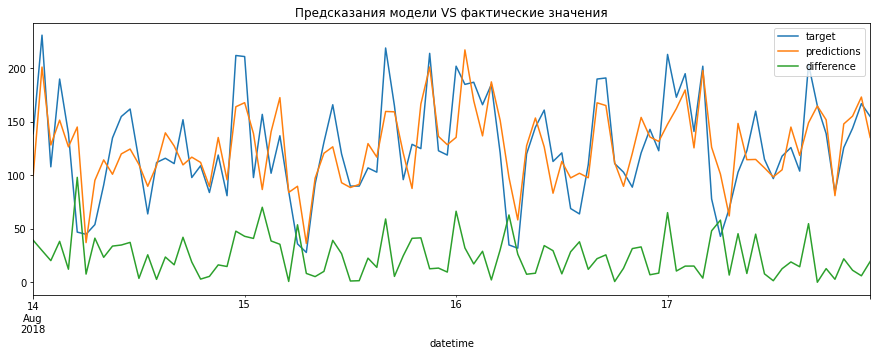

In [105]:
values_test = pd.DataFrame()
values_test['target'] = target_test
values_test['predictions'] = predictions_test_linear
values_test['difference'] = abs(values_test['target'] - values_test['predictions'])
print('Минимальное отклонение:', values_test['difference'].min())
print('Максимальное отклонение:', values_test['difference'].max())
values_test = values_test['2018-08-14':'2018-08-17'] #для анализа возьмем данные за 3 дня
values_test.plot(title='Предсказания модели VS фактические значения', figsize=(15, 5))

**Вывод.** На тестовой выборке наилучший результат показала модель линейной регрессии с гиперпараметрами по умолчанию (RMSE = 36.9). При этом это самая быстрая модель (16 мс). Однако другие модели (LGBM-регрессия и случайный лес) тоже отработали хорошо. Максимальное отклонение составляет 180 заказов, на графике видно, что это пики, сильно отклоняющиеся от средних значений. Можно сказать, что модель достаточно хорошо предсказывает количество заказов в нормальных условиях, однако не может предсказать наплыв клиентов. Для этого нужно вводить дополнительные факторы бизнеса: выходной/рабочий день, праздник или нет и т.д.